In [1]:
import sys


sys.path.insert(0, "/Users/sumanta/Github/extensions/granite-tsfm")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from tsfm_public.models.tspulse.modeling_tspulse import TSPulseForReconstruction
from tsfm_public.toolkit.ad_helpers import AnomalyScoreMethods
from tsfm_public.toolkit.time_series_anomaly_detection_pipeline import TimeSeriesAnomalyDetectionPipeline

In [3]:
data_path = "https://huggingface.co/datasets/AutonLab/Timeseries-PILE/resolve/main/anomaly_detection/TSB-UAD-Public/IOPS/KPI-4d2af31a-9916-3d9f-8a8e-8a268a48c095.test.out"

In [4]:
def load_data(file_path: str, max_length: int, min_length: int):
    data = []
    extra_args = {}
    if file_path.endswith("gz"):
        extra_args["compression"] = "gzip"
    for chunk in pd.read_csv(file_path, header=None, sep=",", chunksize=max_length, *extra_args):
        if (chunk is None) or (chunk.ndim != 2):
            break
        chunk.columns = ["x", "y"]
        chunk["x"] = chunk.x.interpolate(method="cubic").ffill().bfill()
        chunk["y"] = chunk.y.ffill().bfill()
        if chunk.shape[0] > min_length:
            data.append(chunk)
        elif len(data) > 0:
            data[-1] = pd.concat([data[-1], chunk], axis=0)
    return data


def attach_timestamp_column(
    df: pd.DataFrame, time_col: str = "timestamp", freq: str = "D", start_date: str = "2022-01-01"
):
    n = df.shape[0]
    if time_col not in df:
        df[time_col] = pd.date_range(start_date, freq=freq, periods=n)
    return df

In [5]:
max_length, min_length = 5_000, 2_000

data = load_data(data_path, max_length, min_length)

In [6]:
df = attach_timestamp_column(pd.concat(data), freq="5min")

<Axes: xlabel='timestamp'>

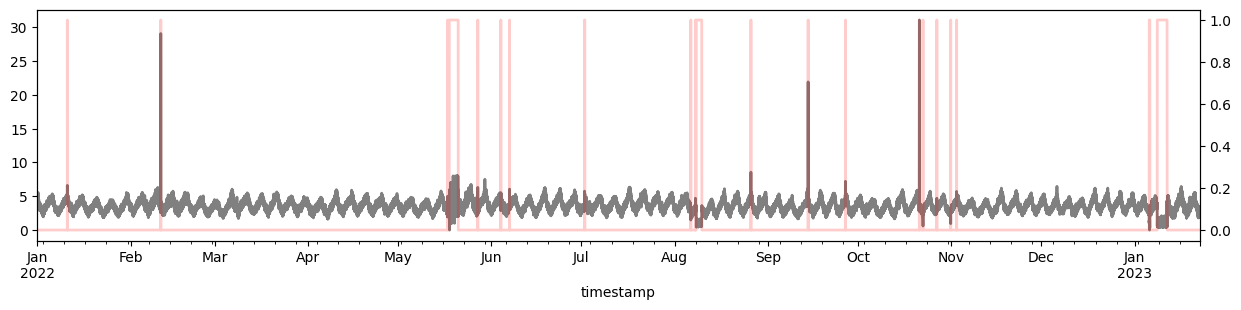

In [7]:
dfx = df.set_index("timestamp")
fig, ax = plt.subplots(1, 1, figsize=(15, 3))

ax2 = ax.twinx()
dfx.x.plot(ax=ax, color="gray", linewidth=2)
dfx.y.plot(ax=ax2, color="red", alpha=0.2, linewidth=2)

In [8]:
path_to_tspulse_model = "ibm-granite/granite-timeseries-tspulse-r1"
zeroshot_model = TSPulseForReconstruction.from_pretrained(
    path_to_tspulse_model,
    num_input_channels=1,
    revision="main",
    mask_type="user",
)

In [34]:
pipeline = TimeSeriesAnomalyDetectionPipeline(
    zeroshot_model,
    timestamp_column="timestamp",
    target_columns=["x"],
    prediction_mode=[
        AnomalyScoreMethods.TIME_RECONSTRUCTION.value,
        AnomalyScoreMethods.FREQUENCY_RECONSTRUCTION.value,
        # AnomalyScoreMethods.PREDICTIVE.value,
    ],
    aggregation_length=64,
    aggr_function="max",
    smoothing_length=8,
    least_significant_scale=0.2,
    least_significant_score=0.1,
)

Device set to use mps:0


In [35]:
segment_length = 520
step = 64

segments = (df.shape[0] - segment_length) // step

segments = min(segments, 200)

In [36]:
state = {}
results = []

In [37]:
from tqdm import tqdm


start_pos = 50000
for i in tqdm(range(segments)):
    start, end = start_pos + i * step, start_pos + (1 + i) * step + segment_length
    result, state = pipeline(df[start:end], batch_size=256, deployed=True, state=state, align="right")
    results.append(result)

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:34<00:00,  5.83it/s]


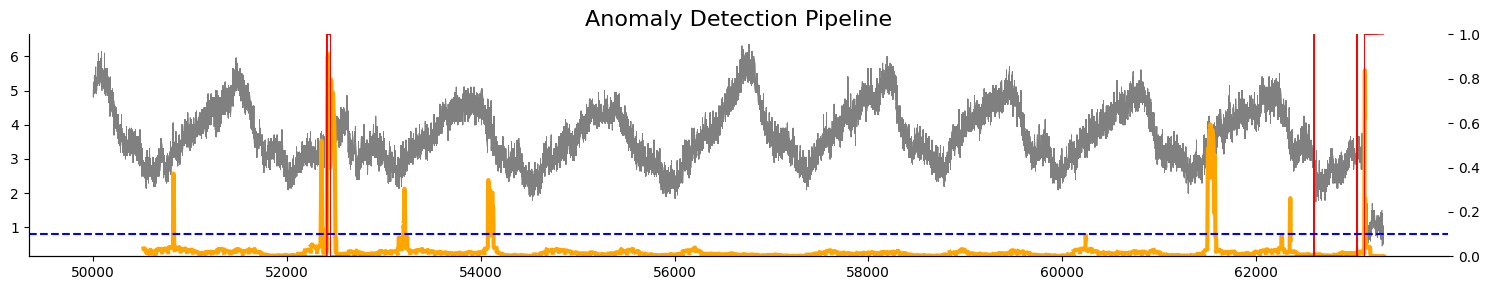

In [38]:
n_plots = 500

n_plots = min(n_plots, len(results))

n_step = len(results) // n_plots

# n_step = 5

fig, ax = plt.subplots(1, 1, sharex="col", figsize=(15, 3))
ax2 = ax.twinx()

for i in range(n_plots):
    segment_id = i * n_step
    # segment_id = 6
    result = results[segment_id]
    result.x.plot(ax=ax, color="gray", linewidth=0.5)
    result.anomaly_score[-64:].plot(ax=ax2, color="orange", linewidth=3, label="Anomaly Score")
    result.y.plot(ax=ax2, color="red", linewidth=0.5, label="Anomaly Event")

ax2.set_ylim(0, 1)
ax.set_title("Anomaly Detection Pipeline", fontsize=16)
ax2.axhline(y=0.1, color="blue", linestyle="dashed")

for s in ["top", "right"]:
    ax.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)

plt.tight_layout()

In [39]:
state

{'time': {'upper': [3.154590368270874],
  'lower': [0.027151312679052353],
  'score2_mean': [0.07008650566021028],
  'score_mean': [0.2184027498860725],
  'score_history_length': 10584,
  'sigma_factor': 6.0,
  'max_history_length': 10000,
  'eps': 0.01,
  'running_std': [[0.6172110327356624]],
  'running_size': 116601},
 'fft': {'upper': [3.0593228340148926],
  'lower': [0.026211552321910858],
  'score2_mean': [0.06915155862418222],
  'score_mean': [0.21899469583574632],
  'score_history_length': 10584,
  'sigma_factor': 6.0,
  'max_history_length': 10000,
  'eps': 0.01,
  'running_std': [[0.6172110327356624]],
  'running_size': 116601}}

In [43]:
pipeline2 = TimeSeriesAnomalyDetectionPipeline(
    zeroshot_model,
    timestamp_column="timestamp",
    target_columns=["x"],
    prediction_mode=[
        AnomalyScoreMethods.TIME_RECONSTRUCTION.value,
        AnomalyScoreMethods.FREQUENCY_RECONSTRUCTION.value,
        AnomalyScoreMethods.PREDICTIVE.value,
    ],
    aggregation_length=64,
    aggr_function="max",
    smoothing_length=8,
    least_significant_scale=0.2,
    least_significant_score=0.1,
)

Device set to use mps:0


In [44]:
%%time
start, end = start_pos, start_pos + 12500
result2 = pipeline2(df[start:end], batch_size=256)

CPU times: user 4.77 s, sys: 1.15 s, total: 5.92 s
Wall time: 15.5 s


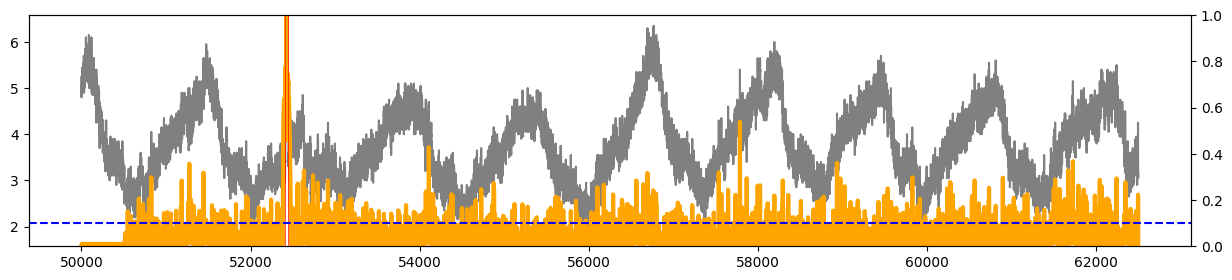

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax2 = ax.twinx()
result2.x.plot(ax=ax, color="gray")
result2.anomaly_score.plot(ax=ax2, color="orange", linewidth=3)
result2.y.plot(ax=ax2, color="red", linewidth=0.5)
ax2.set_ylim(0, 1)
ax2.axhline(y=0.1, color="blue", linestyle="dashed")

In [18]:
segments

200